<a href="https://colab.research.google.com/github/DS-Ankit/DataSciencealgorithm/blob/master/stockprice_TIme_series_Arima_Lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


loading Data of Goldman sachs

In [2]:
data = pd.read_csv('gs.us.txt', sep=',', header=0).fillna(0)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-05-04,67.665,68.780,62.329,62.659,24472946,0
1,1999-05-05,62.213,62.213,58.991,61.547,8295140,0
2,1999-05-06,60.542,61.773,59.712,60.488,3185852,0
3,1999-05-07,60.488,66.671,59.429,65.998,5331091,0
4,1999-05-10,65.331,65.441,62.549,62.941,2839054,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


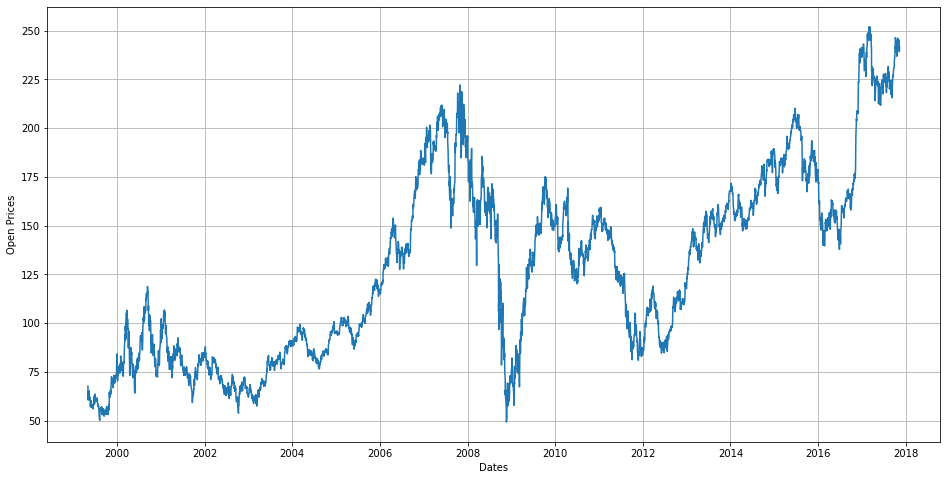

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('gs.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
#data = data.loc['2012-11-10':'2017-11-10']
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open']);

No handles with labels found to put in legend.


          t-1       t+1
t-1  1.000000  0.806935
t+1  0.806935  1.000000


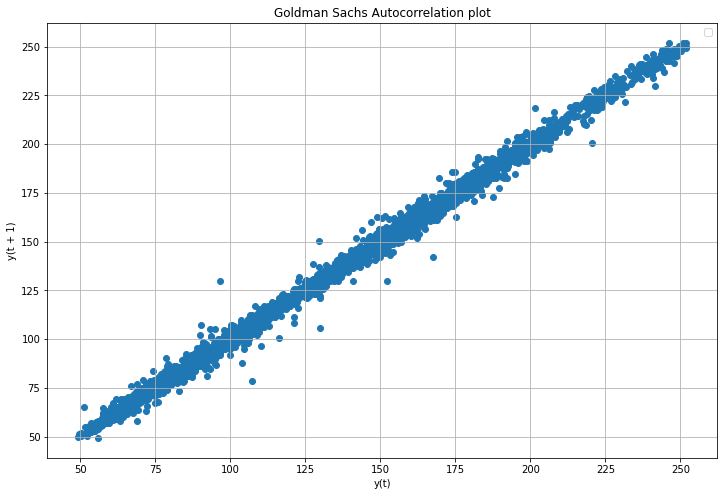

In [5]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=1)
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

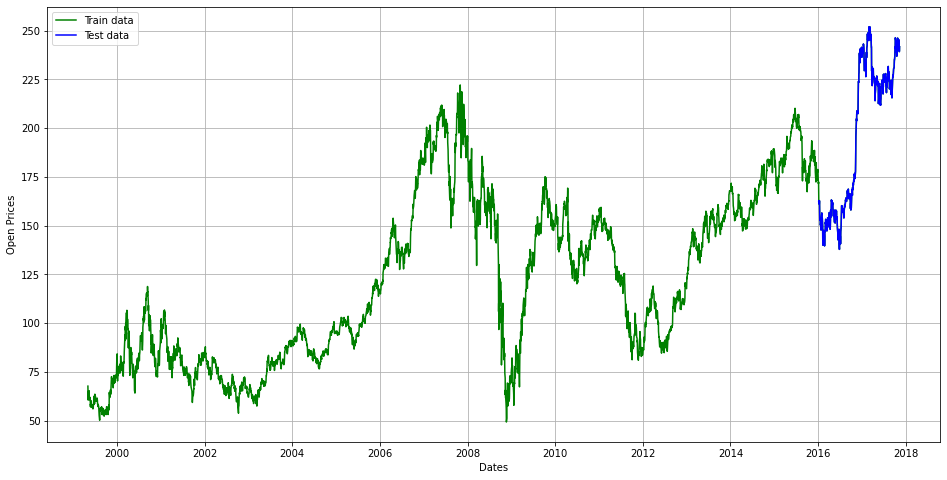

In [6]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag: 31
MSE: 7.3285713652672495
MAE: 2.045978823650137
RMSE: 2.707133422139967


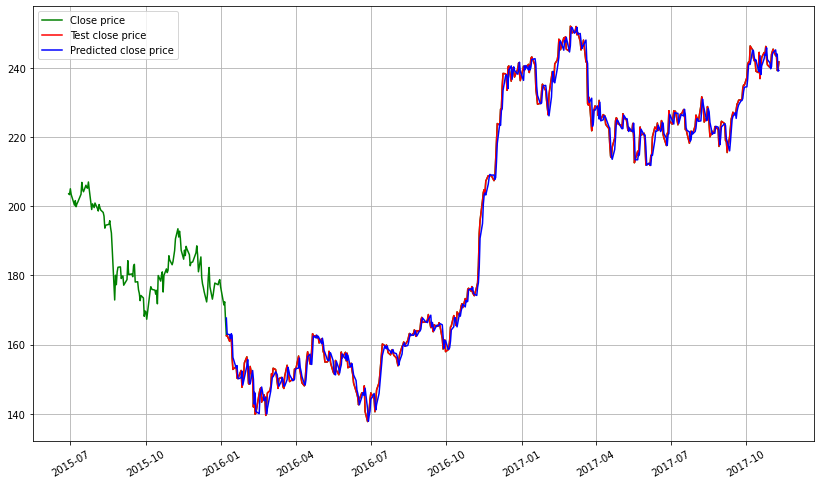

In [7]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

train_ar = train_data['Open']
test_ar = test_data['Open']
# train autoregression
model = AR(train_ar)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
    
plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(test_data['Open'], predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Open'], predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Open'], predictions))
print('RMSE: '+str(rmse))

plt.savefig('ar_model.pdf')

Arima


<Figure size 1152x576 with 0 Axes>

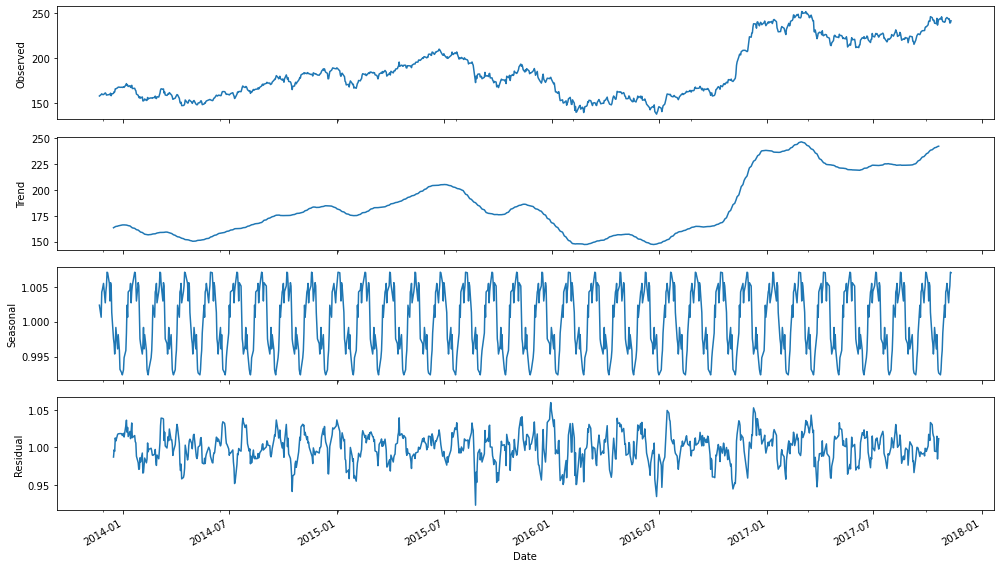

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
data_arima = data['Open']
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_arima[-1000:], model='multiplicative', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

In [9]:
train_arima = train_data['Open']
test_arima = test_data['Open']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 7.214439101150049
MAE: 2.0280254317352617
RMSE: 2.6859707930560317


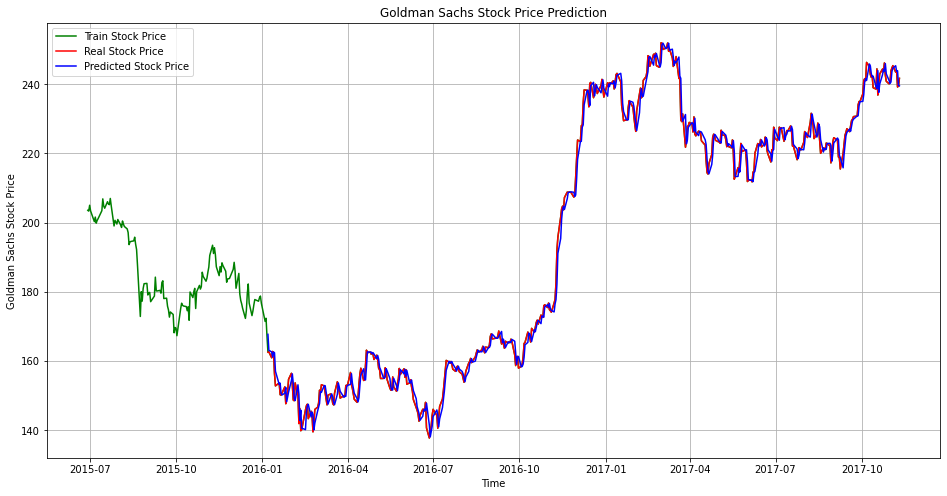

In [10]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

In [0]:
train = train_data.iloc[:, 0:1].values # selecting open prices

Scale data

In [0]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 

In [0]:
X_train = []
y_train = []
timesteps = 7
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

After reshaping and creating data Structure now time for RNN


In [15]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 40, batch_size = 32)


Epoch 1/40
4187/4187 [==============================] - 4s 967us/step - loss: 0.0234
Epoch 2/40
4187/4187 [==============================] - 3s 624us/step - loss: 0.0038
Epoch 3/40
4187/4187 [==============================] - 3s 653us/step - loss: 0.0032
Epoch 4/40
4187/4187 [==============================] - 3s 621us/step - loss: 0.0029
Epoch 5/40
4187/4187 [==============================] - 3s 620us/step - loss: 0.0029
Epoch 6/40
4187/4187 [==============================] - 3s 653us/step - loss: 0.0027
Epoch 7/40
4187/4187 [==============================] - 3s 661us/step - loss: 0.0026
Epoch 8/40
4187/4187 [==============================] - 3s 625us/step - loss: 0.0026
Epoch 9/40
4187/4187 [==============================] - 3s 650us/step - loss: 0.0027
Epoch 10/40
4187/4187 [==============================] - 3s 636us/step - loss: 0.0025
Epoch 11/40
4187/4187 [==============================] - 3s 679us/step - loss: 0.0025
Epoch 12/40
4187/4187 [==============================] - 3s 681

Making prediction


In [0]:
real_stock_price = test_data.iloc[:,0:1].values # taking open price

In [0]:
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [0]:
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

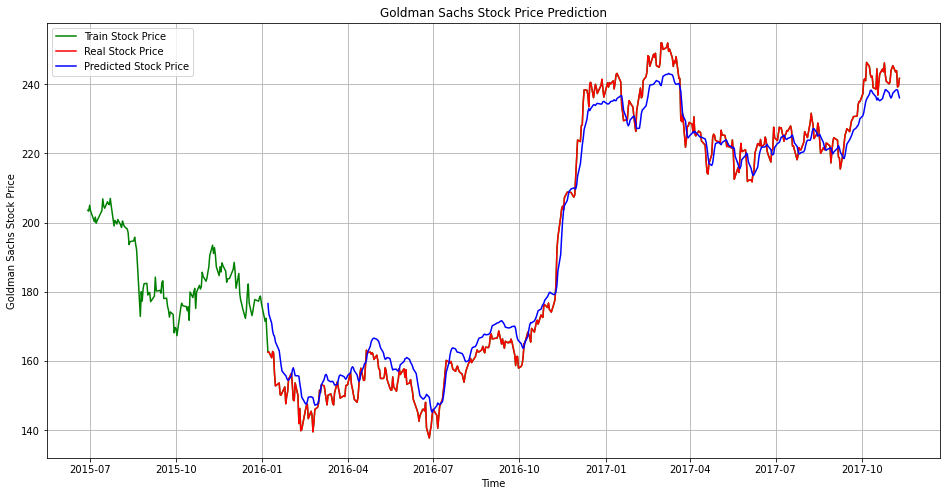

MSE: 27.42727771499332
MAE: 4.360119146637027
RMSE: 5.237105852949062


In [19]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))
